
# Lab_3a: Classifying Names with a Character-Level RNN


We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:


    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


In the  data directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.


In [19]:
import os
import os.path
import gdown
import zipfile
from io import open
import glob
import torch
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
id = "16iH4JCq_hV7O3X-VtBiBhpGTp0WaZXU7"
output = "data_lab3a.zip"
path = "./data_lab3a.zip"
if not os.path.exists(path):
  gdown.download(id=id, output=output, quiet=False)
  with zipfile.ZipFile(output, "r") as zip:
    zip.extractall("./")
    path = zip.namelist()[0]

Downloading...
From: https://drive.google.com/uc?id=16iH4JCq_hV7O3X-VtBiBhpGTp0WaZXU7
To: /content/data_lab3a.zip
100%|██████████| 2.89M/2.89M [00:00<00:00, 123MB/s]


In [3]:
def findFiles(path): return glob.glob(path)

print(findFiles('data_lab3a/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Write a function that reads a file and splits it into lines

def readLines(filename):

### SOLUTION BEGIN


### SOLUTION END

for filename in findFiles('data_lab3a/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data_lab3a/names/Russian.txt', 'data_lab3a/names/Chinese.txt', 'data_lab3a/names/Spanish.txt', 'data_lab3a/names/Czech.txt', 'data_lab3a/names/Vietnamese.txt', 'data_lab3a/names/Italian.txt', 'data_lab3a/names/Scottish.txt', 'data_lab3a/names/Portuguese.txt', 'data_lab3a/names/Arabic.txt', 'data_lab3a/names/Dutch.txt', 'data_lab3a/names/English.txt', 'data_lab3a/names/Japanese.txt', 'data_lab3a/names/Polish.txt', 'data_lab3a/names/Irish.txt', 'data_lab3a/names/Greek.txt', 'data_lab3a/names/French.txt', 'data_lab3a/names/Korean.txt', 'data_lab3a/names/German.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Write a function that turn a line into a <line_length x 1 x n_letters> or an array of one-hot letter vectors
def lineToTensor(line):

### SOLUTION BEGIN


### SOLUTION END

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.





In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8947, -2.8668, -2.8602, -2.8600, -2.9132, -2.8828, -3.0027, -2.8604,
         -2.8197, -2.8940, -2.8104, -2.9539, -2.8941, -2.9002, -2.7832, -2.9685,
         -2.9496, -2.9401]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




## Training
Preparing for Training
----------------------

write helper functions to interpret the output of the network, which we know to be a likelihood of each category.




In [10]:
# Write a helper function that print the greatest value from the resulted likelihood of each category
def categoryFromOutput(output):

### SOLUTION BEGIN

### SOLUTION END

print(categoryFromOutput(output))

('Greek', 14)


We will also want a quick way to get a training example (a name and its
language):




In [12]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Dutch / line = Altena
category = French / line = Blanc
category = German / line = Wendell
category = Russian / line = Lilov
category = Greek / line = Gravari
category = Czech / line = Kosko
category = German / line = Essert
category = Dutch / line = Haenraets
category = Dutch / line = Marqueringh
category = Scottish / line = Muir


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [13]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(???, ???)

    loss = criterion(???, ???)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [17]:
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.6491 Reynold / Spanish ✗ (Irish)
10000 10% (0m 13s) 2.5166 Rushton / Russian ✗ (English)
15000 15% (0m 20s) 1.9394 Tron / Korean ✗ (Vietnamese)
20000 20% (0m 27s) 2.4134 Watt / German ✗ (Scottish)
25000 25% (0m 33s) 2.2434 O'Connor / Scottish ✗ (Irish)
30000 30% (0m 41s) 0.3693 Pharlain / Irish ✓
35000 35% (0m 47s) 0.7242 Vu / Vietnamese ✓
40000 40% (0m 54s) 2.3397 Kibblewhite / Scottish ✗ (English)
45000 45% (1m 1s) 2.0785 Smits / English ✗ (Dutch)
50000 50% (1m 9s) 0.0505 Gribov / Russian ✓
55000 55% (1m 16s) 1.5212 Xiong / Chinese ✓
60000 60% (1m 22s) 1.5533 Otani / Italian ✗ (Japanese)
65000 65% (1m 30s) 3.1726 Onoe / French ✗ (Japanese)
70000 70% (1m 36s) 5.0188 Paulis / Greek ✗ (Dutch)
75000 75% (1m 44s) 1.2001 Naomhan / Irish ✓
80000 80% (1m 51s) 1.1434 Neville / Irish ✓
85000 85% (1m 58s) 0.1529 O'Grady / Irish ✓
90000 90% (2m 4s) 0.8047 Penders / Dutch ✓
95000 95% (2m 12s) 5.0274 Andringa / Czech ✗ (Dutch)
100000 100% (2m 18s) 0.6453 Milne / Scottish ✓


### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:




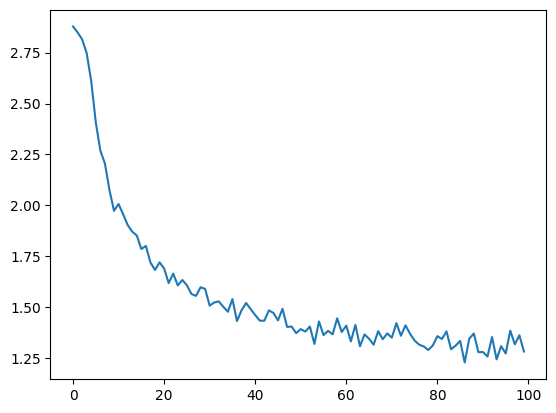

In [18]:
plt.figure()
plt.plot(all_losses)

## Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




<ipython-input-20-a5b341ffc3a3>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-20-a5b341ffc3a3>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


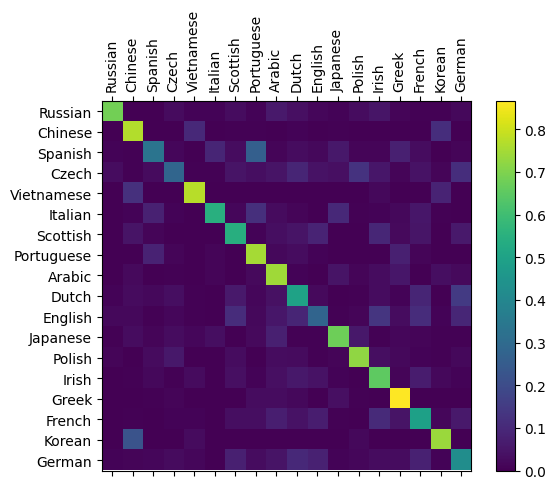

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




### Running on User Input




In [25]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.71) Russian
(-1.05) Czech
(-2.52) English

> Jackson
(-1.11) Scottish
(-1.78) English
(-1.78) Czech

> Satoshi
(-0.78) Arabic
(-1.79) Italian
(-1.89) Polish
